In [1]:
### 입력으로 상호명을 받으면 업종분류를 반환하는 프로그램

In [2]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
import pickle
import seaborn as sns
import time
import os

from tqdm import tqdm
from konlpy.tag import Mecab
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix
from transformers import BertTokenizerFast, BertConfig, BertModel # Bert 모델과 토크나이저
from torch.utils.data import Dataset, DataLoader
from collections import Counter

plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

c:\code\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
torch.cuda.init()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.cuda.reset_peak_memory_stats(device=None)
print("현재 디바이스:", device)

os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
os.environ['CUDA_VISIBLE_DEVICES'] = "0"
os.environ['TORCH_USE_CUDA_DSA'] = "1"

현재 디바이스: cuda


In [4]:
# 전처리된 CSV 파일 로드
def load_processed_data(file_path):
    """
    처리된 CSV 파일을 로드하는 함수
    """
    df = pd.read_csv(file_path)
    print(f"로드된 데이터 크기: {df.shape}")
    print(f"컬럼 목록: {df.columns.tolist()}")
    
    # 필요한 열만 추출 (업체명과 클래스)
    result_df = df[['상호명_Regulated', '클래스']].copy()
    
    # 컬럼명 통일
    result_df.columns = ['store', 'class']
    
    print(f"전처리 후 데이터 크기: {result_df.shape}")
    return result_df

In [5]:
data_df = load_processed_data('./processed_data/region_all_processed_data.csv')

로드된 데이터 크기: (1818487, 5)
컬럼 목록: ['상가업소번호', '지역', '상호명_Regulated', '업종소분류_Regulated', '클래스']
전처리 후 데이터 크기: (1818487, 2)


In [6]:
def split_dataset(df, test_size=0.2, random_state=42):
    """
    데이터를 훈련용과 테스트용으로 분할하는 함수
    """
    # 클래스 분포 확인
    num_classes = df['class'].nunique()
    print(f"고유 클래스 수: {num_classes}")
    
    # 데이터셋 분할 (stratify로 클래스 분포 유지)
    train_df, test_df = train_test_split(
        df, 
        test_size=test_size, 
        random_state=random_state,
        stratify=df['class']
    )
    
    print(f"훈련 데이터 크기: {train_df.shape}")
    print(f"테스트 데이터 크기: {test_df.shape}")

    return train_df, test_df

In [7]:
train_df, test_df = split_dataset(data_df)

고유 클래스 수: 247
훈련 데이터 크기: (1454789, 2)
테스트 데이터 크기: (363698, 2)


In [8]:
# 클래스별 샘플 수 세기
class_counts = Counter(train_df['class'])
num_classes = len(class_counts)
# 클래스 인덱스 매핑
class_to_idx = {cls: i for i, cls in enumerate(sorted(class_counts.keys()))}

In [9]:
train_df
# test_df

,store,class
1607566,드림아트,80
1385651,온가족국수,35
313687,알로하훌라스튜디오,76
1811134,전자담배라미야김제점,117
1391266,몽키리코에프엔비완주봉동지점,214
...,...,...
354405,크린토피아홈플러스서,123
798530,신한철물,207
1446488,갈목철공소,11
971736,이사랑서울치과의원,211


In [10]:
train_df.groupby(by=['class']).count()

,store
class,
0,4147
1,6031
2,582
3,2262
4,1308
...,...
242,1275
243,734
244,14120


In [11]:
tokenizer = BertTokenizerFast.from_pretrained('kykim/bert-kor-base')
token1 = tokenizer.tokenize("봉암쇼핑")
token2 = tokenizer.tokenize("밀사랑손칼국수")
token3 = tokenizer.tokenize("태민건축적산사무소")
token4 = tokenizer.tokenize("스타벅스R리저브강남대로점")
token5 = tokenizer.tokenize("로그인커피")
token6 = tokenizer.tokenize("스타벅스R리저브강남속편한치과건너편점")
print(token1, token2, token3, token4, token5, token6)

mecab = Mecab(dicpath='C:/mecab/mecab-ko-dic')
token1 = mecab.morphs("봉암쇼핑")
token2 = mecab.morphs("밀사랑손칼국수")
token3 = mecab.morphs("태민건축적산사무소")
token4 = mecab.morphs("스타벅스R리저브강남대로점")
token5 = mecab.morphs("로그인커피")
token6 = mecab.morphs("스타벅스R리저브강남속편한치과건너편점")
print(token1, token2, token3, token4, token5, token6)

['봉', '##암', '##쇼핑'] ['밀', '##사랑', '##손', '##칼국수'] ['태', '##민', '##건축', '##적', '##산', '##사무소'] ['스타벅스', '##r', '##리', '##저', '##브', '##강', '##남', '##대로', '##점'] ['로그인', '##커피'] ['스타벅스', '##r', '##리', '##저', '##브', '##강', '##남', '##속', '##편한', '##치', '##과', '##건', '##너', '##편', '##점']
['봉암', '쇼핑'] ['밀사', '랑', '손칼국수'] ['태민', '건축', '적', '산', '사무소'] ['스타', '벅스', 'R', '리저브', '강남대로', '점'] ['로그인', '커피'] ['스타', '벅스', 'R', '리저브', '강남', '속편', '한', '치과', '건너편', '점']


In [3]:
class TokenDataset(Dataset):
    def __init__(self, dataframe, tokenizer_pretrained):
        # sentence, label 컬럼으로 구성된 데이터프레임 전달
        self.data = dataframe        
        # Huggingface 토크나이저 생성
        self.tokenizer = BertTokenizerFast.from_pretrained(tokenizer_pretrained)
  
    def __len__(self):
        return len(self.data)
  
    def __getitem__(self, idx):
        sentence = self.data.iloc[idx]['store']
        label = self.data.iloc[idx]['class']

        # 토큰화 처리
        tokens = self.tokenizer(
            str(sentence),                # 1개 문장 
            return_tensors='pt',     # 텐서로 반환
            truncation=True,         # 잘라내기 적용
            padding='max_length',    # 패딩 적용
            max_length=60,          # 최대 길이 60
            add_special_tokens=True  # 스페셜 토큰 적용
        )

        input_ids = tokens['input_ids'].squeeze(0)           # 2D -> 1D
        attention_mask = tokens['attention_mask'].squeeze(0) # 2D -> 1D
        token_type_ids = torch.zeros_like(attention_mask)

        # input_ids, attention_mask, token_type_ids 이렇게 3가지 요소를 반환하도록 합니다.
        # input_ids: 토큰
        # attention_mask: 실제 단어가 존재하면 1, 패딩이면 0 (패딩은 0이 아닐 수 있습니다)
        # token_type_ids: 문장을 구분하는 id. 단일 문장인 경우에는 전부 0
        return {
            'input_ids': input_ids,
            'attention_mask': attention_mask, 
            'token_type_ids': token_type_ids,
        }, torch.tensor(label)

In [12]:
train_data = TokenDataset(train_df, 'kykim/bert-kor-base')
test_data = TokenDataset(test_df, 'kykim/bert-kor-base')

# DataLoader로 이전에 생성한 Dataset를 지정하여, batch 구성, shuffle, num_workers 등을 설정합니다.
train_loader = DataLoader(train_data, batch_size=64, shuffle=False, num_workers=0)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False, num_workers=0)

In [12]:
# 1개의 batch 꺼내기
inputs, labels = next(iter(train_loader))

# 데이터셋을 device 설정
inputs = {k: v.to(device) for k, v in inputs.items()}
labels.to(device)

tensor([ 80,  35,  76, 117, 214, 213, 214,  66, 107,  33, 153, 150,  80,  60,
        183, 103, 214, 180,  18,  74, 214,  87, 228, 107, 112,  18,  91,  87,
         55,   6,  55, 127,  34, 184,  72, 231, 204, 147, 157,  55, 212, 214,
         34, 204,  11,  60,  80, 112, 214,  87, 134,  41,  66, 214, 241, 241,
        228,  91, 229, 216, 124,  85,  74, 103], device='cuda:0')

In [12]:
class BertCNNModel(nn.Module):
    def __init__(self, bert_pretrained, num_classes=247, dropout_rate=0.5, kernel_sizes=[2,3,4], num_filters=128):
        super().__init__()
        self.bert = BertModel.from_pretrained(bert_pretrained)
        self.convs = nn.ModuleList([
            nn.Conv1d(768, num_filters, k) for k in kernel_sizes
        ])
        self.dropout = nn.Dropout(dropout_rate)
        self.fc = nn.Linear(num_filters * len(kernel_sizes), num_classes)

    def forward(self, input_ids, attention_mask, token_type_ids):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
        x = outputs['last_hidden_state'].transpose(1, 2)  # [batch, 768, seq_len]
        conv_outs = [F.relu(conv(x)) for conv in self.convs]
        pooled = [F.max_pool1d(c, c.size(2)).squeeze(2) for c in conv_outs]
        cat = torch.cat(pooled, dim=1)
        cat = self.dropout(cat)
        logits = self.fc(cat)
        return logits

In [13]:
tokenizer_pretrained = 'kykim/bert-kor-base'
bert_tokenizer = BertTokenizerFast.from_pretrained(tokenizer_pretrained)
bert = BertCNNModel(tokenizer_pretrained, num_classes=len(class_to_idx)).to(device)
bert.to(device)

BertCNNModel(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(42000, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_

In [18]:
# loss 정의: CrossEntropyLoss
loss_fn = nn.CrossEntropyLoss()

# 옵티마이저 정의: bert.paramters()와 learning_rate 설정
optimizer = optim.Adam(bert.parameters(), lr=1e-5)

In [14]:
model_name = 'bert-kor-cnn2_all'
time_date = '2505091730'
save_path = f'./saved_model/{model_name}_{time_date}'

In [15]:
bert.load_state_dict(torch.load(save_path + f'/{model_name}_{time_date}.pth'))

<All keys matched successfully>

In [16]:
tokenizer = BertTokenizerFast.from_pretrained('kykim/bert-kor-base')
labels = pickle.load(open('./processed_data/category_mapping.pkl', 'rb'))
labels = {v: k for k, v in labels.items()}
labels

{'0': 'PC방',
 '1': '가구',
 '2': '가발',
 '3': '가방',
 '4': '가스 충전소',
 '5': '가전제품',
 '6': '가전제품 수리',
 '7': '가정용 연료',
 '8': '가죽/가방/신발 수선',
 '9': '가축 사료',
 '10': '간이 음식점(기타)',
 '11': '개인/가정용품 수리(기타)',
 '12': '건강보조식품',
 '13': '건물 및 토목 엔지니어링 서비스',
 '14': '건설/건축자재',
 '15': '건설기계/장비 대여업',
 '16': '건어물/젓갈',
 '17': '건축 설계 및 관련 서비스',
 '18': '건축물 일반 청소',
 '19': '결혼 상담 서비스',
 '20': '경양식',
 '21': '경영 컨설팅',
 '22': '고용 알선업',
 '23': '곡물/곡분',
 '24': '골프 연습장',
 '25': '곱창 전골/구이',
 '26': '공인노무사',
 '27': '공인회계사',
 '28': '광고 대행',
 '29': '광고 매체 판매',
 '30': '광고물 설계/제작업',
 '31': '교육기관(기타)',
 '32': '교육컨설팅',
 '33': '구내식당',
 '34': '국/탕/찌개류',
 '35': '국수/칼국수',
 '36': '기념품점',
 '37': '기숙사/고시원',
 '38': '기타 개인/가정용품 대여업',
 '39': '기타 건설/건축자재',
 '40': '기타 광고 관련 서비스',
 '41': '기타 교육지원 서비스',
 '42': '기타 기술/직업 훈련학원',
 '43': '기타 동남아식 전문',
 '44': '기타 법무관련 서비스',
 '45': '기타 사무 지원 서비스',
 '46': '기타 산업용 기계/장비 대여업',
 '47': '기타 서양식 음식점',
 '48': '기타 스포츠시설 운영업',
 '49': '기타 엔지니어링 서비스',
 '50': '기타 여행 보조/예약 서비스',
 '51': '기타 예술/스포츠 교육기관',
 '52': 

In [17]:
class CustomPredictor():
    def __init__(self, model, tokenizer, labels: dict):
        self.model = model
        self.tokenizer = tokenizer
        self.labels = labels
        
    def predict(self, sentence):
        # 토큰화 처리
        tokens = self.tokenizer(
            str(sentence),                # 1개 문장 
            return_tensors='pt',     # 텐서로 반환
            truncation=True,         # 잘라내기 적용
            padding='max_length',    # 패딩 적용
            max_length=60,          # 최대 길이 60
            add_special_tokens=True  # 스페셜 토큰 적용
        )
        tokens.to(device)
        prediction = self.model(**tokens)
        prediction = F.softmax(prediction, dim=1)
        output = prediction.argmax(dim=1).item()
        prob = prediction.max(dim=1)[0].item() * 100
        result = self.labels[str(output)]
        return result, prob

In [18]:
predictor = CustomPredictor(bert, tokenizer, labels)

predict_time = 9999
for i in range(10):
    start_time = time.time()
    query = test_df.iloc[i]['store']
    pred, acc = predictor.predict(query)
    print(f'{query} -> {pred} ({acc:.2f}%)')
    end_time = time.time()
    elapsed_time = end_time - start_time
    if elapsed_time < predict_time:
        predict_time = elapsed_time
query = "스타벅스R리저브강남속편한치과건너편점"
pred = predictor.predict(query)
print(query, pred)
print(f"예측 소요 시간: {predict_time:.4f}초")

캐치캐치아이스 -> 장난감 (13.03%)
아엠 -> 카페 (7.76%)
새틴 -> 카페 (6.75%)
네일즈247 -> 네일숍 (94.58%)
커피랑도서관대구본동점 -> 독서실/스터디 카페 (98.78%)
꿈꾸는요리사 -> 기타 기술/직업 훈련학원 (10.87%)
메타교육 -> 입시·교과학원 (21.51%)
나선재 -> 펜션 (23.06%)
평화이앤씨주 -> 건물 및 토목 엔지니어링 서비스 (51.49%)
약령 -> 건강보조식품 (22.91%)
스타벅스R리저브강남속편한치과건너편점 ('카페', 90.132737159729)
예측 소요 시간: 0.0249초


In [29]:
pred = predictor.predict("에스.티.피.시 짱치킨")
print(f"예측 결과: {pred[0]}, 확률: {pred[1]:.2f}%")

예측 결과: 치킨, 확률: 56.86%


In [23]:
def batch_predict(model, dataloader, labels_dict, device, test_df):
    # 배치 단위로 예측 수행
    model.eval()
    results = []
    idx = 0
    with torch.no_grad():
        for inputs, labels in tqdm(dataloader):
            batch_size = len(labels)
            inputs = {k: v.to(device) for k, v in inputs.items()}
            labels = labels.to(device)
            # 예측 수행
            outputs = model(**inputs)
            probs = F.softmax(outputs, dim=1)
            preds = torch.argmax(probs, dim=1)
            confidence = torch.max(probs, dim=1)[0]
            # 결과 저장
            for i in range(batch_size):
                pred_class = labels_dict[str(preds[i].item())]
                true_class = labels_dict[str(labels[i].item())]
                results.append({
                    'query': test_df.iloc[idx]['store'],
                    'pred': pred_class,
                    'label': true_class,
                    'prob': f'{confidence[i].item()*100:.2f}%'
                })
                idx += 1
    return pd.DataFrame(results)

# 평가용 데이터로더 설정 (배치 크기 증가)
test_loader = DataLoader(test_data, batch_size=256, shuffle=False, num_workers=0)

# 배치 예측 실행
test_query_df = batch_predict(bert, test_loader, labels, device, test_df)

100%|██████████| 1421/1421 [27:12<00:00,  1.15s/it] 


In [24]:
test_query_df

,query,pred,label,prob
0,캐치캐치아이스,장난감,슈퍼마켓,9.98%
1,아엠,카페,명함/간판/광고물 제작,6.34%
2,새틴,카페,여관/모텔,6.28%
3,네일즈247,네일숍,네일숍,95.03%
4,커피랑도서관대구본동점,독서실/스터디 카페,독서실/스터디 카페,99.45%
...,...,...,...,...
363693,천사차일드유,서점,의류 대여업,11.06%
363694,녹십자요양병원,요양병원,요양병원,89.87%
363695,문화떡방앗간,떡/한과,떡/한과,99.06%
363696,타미진갤러리아센터시티,기타 의류,여성 의류,41.45%


In [25]:
score = test_query_df['pred'].eq(test_query_df['label']).sum() / len(test_query_df) * 100
score

np.float64(66.24562136717826)

In [26]:
# Error Analysis
error_df = test_query_df[test_query_df['pred'] != test_query_df['label']].copy()
error_df.head(20)

,query,pred,label,prob
0,캐치캐치아이스,장난감,슈퍼마켓,9.98%
1,아엠,카페,명함/간판/광고물 제작,6.34%
2,새틴,카페,여관/모텔,6.28%
5,꿈꾸는요리사,기타 기술/직업 훈련학원,빵/도넛,12.18%
6,메타교육,입시·교과학원,요가/필라테스 학원,32.67%
8,평화이앤씨주,건물 및 토목 엔지니어링 서비스,건축 설계 및 관련 서비스,36.06%
9,약령,건강보조식품,경양식,25.84%
11,웅진NS,컴퓨터/소프트웨어,서점,9.49%
12,삼춘종합집수리,개인/가정용품 수리(기타),인테리어 디자인업,59.98%
13,예술창작소숲,미술학원,예술품,8.25%


In [27]:
pickle.dump(test_query_df, open(f'./saved_model/{model_name}_{time_date}/test_query_df.pkl', 'wb'))
pickle.dump(error_df, open(f'./saved_model/{model_name}_{time_date}/error_df.pkl', 'wb'))

---
### Error 분석

In [28]:
test_query_df = pickle.load(open(f'./saved_model/{model_name}_{time_date}/test_query_df.pkl', 'rb'))
error_df = pickle.load(open(f'./saved_model/{model_name}_{time_date}/error_df.pkl', 'rb'))
error_df.head(20)

,query,pred,label,prob
0,캐치캐치아이스,장난감,슈퍼마켓,9.98%
1,아엠,카페,명함/간판/광고물 제작,6.34%
2,새틴,카페,여관/모텔,6.28%
5,꿈꾸는요리사,기타 기술/직업 훈련학원,빵/도넛,12.18%
6,메타교육,입시·교과학원,요가/필라테스 학원,32.67%
8,평화이앤씨주,건물 및 토목 엔지니어링 서비스,건축 설계 및 관련 서비스,36.06%
9,약령,건강보조식품,경양식,25.84%
11,웅진NS,컴퓨터/소프트웨어,서점,9.49%
12,삼춘종합집수리,개인/가정용품 수리(기타),인테리어 디자인업,59.98%
13,예술창작소숲,미술학원,예술품,8.25%


In [29]:
acc = test_query_df['pred'].eq(test_query_df['label']).sum() / len(test_query_df) * 100
print(f"Accuracy: {acc:.2f}%")

Accuracy: 66.25%


In [30]:
# sklearn classification_report로 정밀도, 재현율 등 계산
print(classification_report(test_query_df['label'], test_query_df['pred'], digits=4, zero_division=0))

                      precision    recall  f1-score   support

                 PC방     0.8515    0.9122    0.8808      1037
                  가구     0.6848    0.5849    0.6309      1508
                  가발     0.2500    0.0690    0.1081       145
                  가방     0.6146    0.4028    0.4867       566
              가스 충전소     0.7959    0.7156    0.7536       327
                가전제품     0.4066    0.2545    0.3131      1163
             가전제품 수리     0.5083    0.5511    0.5289      1662
              가정용 연료     0.7877    0.8116    0.7995       759
         가죽/가방/신발 수선     0.5342    0.2910    0.3768       134
               가축 사료     0.2785    0.0859    0.1313       256
          간이 음식점(기타)     0.4801    0.1258    0.1993      1153
      개인/가정용품 수리(기타)     0.5282    0.4274    0.4725      1247
              건강보조식품     0.5223    0.6027    0.5596      2351
   건물 및 토목 엔지니어링 서비스     0.3701    0.6716    0.4772      1160
             건설/건축자재     0.6168    0.5228    0.5659       197
       

In [31]:
macro_precision = precision_score(test_query_df['label'], test_query_df['pred'], average='macro')
macro_recall = recall_score(test_query_df['label'], test_query_df['pred'], average='macro')
print(f"Macro Precision: {macro_precision:.2f}, Macro Recall: {macro_recall:.2f}")

c:\code\.venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Macro Precision: 0.62, Macro Recall: 0.56


In [32]:
micro_precision = precision_score(test_query_df['label'], test_query_df['pred'], average='micro')
micro_recall = recall_score(test_query_df['label'], test_query_df['pred'], average='micro')
micro_f1 = f1_score(test_query_df['label'], test_query_df['pred'], average='micro')
print(f"Micro Precision: {micro_precision:.2f}, Micro Recall: {micro_recall:.2f}, Micro F1: {micro_f1:.2f}")

Micro Precision: 0.66, Micro Recall: 0.66, Micro F1: 0.66


In [33]:
error_case_counts = (
    error_df.groupby(['pred', 'label'])
    .size()
    .reset_index(name='count')
    .sort_values(by='count', ascending=False)
)
error_case_counts

,pred,label,count
4816,백반/한정식,돼지고기 구이/찜,1421
7975,요리 주점,백반/한정식,1075
3938,돼지고기 구이/찜,백반/한정식,1031
11065,카페,백반/한정식,873
4881,백반/한정식,요리 주점,847
...,...,...,...
12681,횟집,산업설비; 운송장비 및 공공장소 청소,1
12687,횟집,시각 디자인업,1
32,PC방,안경렌즈,1
33,PC방,액세서리/잡화,1


---
### 특정 case 탐색

In [ ]:
error_case_한식_df = test_query_df[
    ((test_query_df['label'] == '돼지고기 구이/찜') & (test_query_df['pred'] == '백반/한정식'))|
    ((test_query_df['label'] == '백반/한정식') & (test_query_df['pred'] == '돼지고기 구이/찜'))
    ]
error_case_한식_df

,query,pred,label,prob
66,조선마루,백반/한정식,돼지고기 구이/찜,30.48%
99,송월관2,백반/한정식,돼지고기 구이/찜,21.76%
215,1990루프탑앤그릴,돼지고기 구이/찜,백반/한정식,24.05%
265,신박한뼈구이,백반/한정식,돼지고기 구이/찜,88.18%
273,다솔집,백반/한정식,돼지고기 구이/찜,51.02%
...,...,...,...,...
363091,뼈삼,백반/한정식,돼지고기 구이/찜,50.15%
363357,장수장식당,백반/한정식,돼지고기 구이/찜,71.00%
363420,정직대패,돼지고기 구이/찜,백반/한정식,55.41%
363506,더케이푸드컴퍼니,백반/한정식,돼지고기 구이/찜,29.89%


In [ ]:
error_case_cafe_df = test_query_df[
    ((test_query_df['label'] == '카페') & (test_query_df['pred'] == '빵/도넛'))|
    ((test_query_df['label'] == '빵/도넛') & (test_query_df['pred'] == '카페'))
    ]
error_case_cafe_df

,query,pred,label,prob
64,치즈링,카페,빵/도넛,8.23%
91,아미브레,빵/도넛,카페,21.80%
625,크레플,카페,빵/도넛,14.82%
930,노마드오븐,빵/도넛,카페,60.40%
1168,소금길,카페,빵/도넛,15.53%
...,...,...,...,...
362757,크리미크,카페,빵/도넛,31.45%
362879,푸르파파북창동,카페,빵/도넛,9.95%
362928,단미제과,빵/도넛,카페,74.38%
363068,달달마녀의오븐,빵/도넛,카페,52.25%


In [ ]:
error_case_아이스크림할인점_df = test_query_df[
    (test_query_df['label'] == '아이스크림 할인점') | (test_query_df['pred'] == '아이스크림 할인점')
    ]
error_case_아이스크림할인점_df

,query,pred,label,prob
21325,도깨비냉장고아이스크림할인점캠퍼스타운역점,아이스크림 할인점,아이스크림 할인점,61.86%
43708,아이즈크림평택비전점,슈퍼마켓,아이스크림 할인점,67.51%
46835,아이스달원종점,슈퍼마켓,아이스크림 할인점,73.43%
49835,도깨비냉장고아이스크림할인점라일락,아이스크림 할인점,아이스크림 할인점,45.23%
55894,앙그작,카페,아이스크림 할인점,11.46%
70855,아이스홀릭,슈퍼마켓,아이스크림 할인점,57.99%
75443,도깨비냉장고아이스크림할인점김포걸포북변점,아이스크림 할인점,아이스크림 할인점,54.76%
77275,도깨비냉장고아이스크림할인점 슈퍼마켓,아이스크림 할인점,아이스크림 할인점,54.69%
87586,달쥬아이스크림24,슈퍼마켓,아이스크림 할인점,84.72%
88929,세계과자나라,슈퍼마켓,아이스크림 할인점,67.72%


In [76]:
error_case_치과병원_df = test_query_df[
    (test_query_df['label'] == '치과병원') | (test_query_df['pred'] == '치과병원')
    ]
error_case_치과병원_df

,query,pred,label,prob
494,광진예치과병원,치과병원,치과병원,84.71%
1565,아이엠치과병원,치과병원,치과병원,84.01%
8596,수플란트치과병원,치과병원,치과병원,94.24%
11705,문산연세치과,치과의원,치과병원,97.95%
14978,경로치과,치과의원,치과병원,97.90%
...,...,...,...,...
312487,보스톤미소치과의원,치과의원,치과병원,97.83%
319968,이롬치과의원,치과의원,치과병원,97.64%
326265,여의도이치과,치과의원,치과병원,97.55%
344961,시카고치과병원,치과병원,치과의원,92.29%


In [77]:
error_case_치과의원_df = test_query_df[
    (test_query_df['label'] == '치과의원') | (test_query_df['pred'] == '치과의원')
    ]
error_case_치과의원_df

,query,pred,label,prob
112,분당올치과,치과의원,치과의원,97.79%
167,이오스치과,치과의원,치과의원,97.06%
250,아이온치과의원,치과의원,치과의원,97.18%
626,인천모아치과의원,치과의원,치과의원,97.80%
692,더프라임치과의원,치과의원,치과의원,97.18%
...,...,...,...,...
362972,세종치과의원,치과의원,치과의원,97.64%
363022,서울소담치과,치과의원,치과의원,97.41%
363106,대림미치과의원,치과의원,치과의원,98.17%
363184,토마스치과의원,치과의원,치과의원,98.00%


In [79]:
error_case_공인회계사_df = test_query_df[
    (test_query_df['label'] == '공인회계사') | (test_query_df['pred'] == '공인회계사')
    ]
error_case_공인회계사_df

,query,pred,label,prob
3935,장직수회계사무소,세무사,공인회계사,51.45%
6217,박준호세무회계사무소,세무사,공인회계사,85.43%
6248,우송세무회계,세무사,공인회계사,85.96%
9921,공인회계사김두남사무소,공인회계사,공인회계사,76.96%
10018,임낙정세무회계사무소,세무사,공인회계사,87.06%
...,...,...,...,...
356865,동아세무회계사무소,세무사,공인회계사,81.91%
357191,성기붕세무회계사무소,세무사,공인회계사,87.55%
357419,한맥세무회계,세무사,공인회계사,86.80%
359040,세무사김해교,세무사,공인회계사,96.52%


In [80]:
error_case_세무사_df = test_query_df[
    (test_query_df['label'] == '세무사') | (test_query_df['pred'] == '세무사')
    ]
error_case_세무사_df

,query,pred,label,prob
68,백금선세무회계사무소,세무사,세무사,86.04%
408,택스리더세무회계,세무사,세무사,91.33%
434,세무사이의완사무소,세무사,세무사,96.68%
535,정완식세무회계사무소,세무사,세무사,85.29%
733,정경희세무사사무소,세무사,세무사,93.39%
...,...,...,...,...
363114,로택스법률세무사무소,변호사,세무사,78.57%
363246,세무사김진식사무소,세무사,세무사,96.74%
363415,구본철세무회계사무소,세무사,세무사,86.98%
363497,백석원세무회계사무소,세무사,세무사,85.99%


In [81]:
error_case_예식장업_df = test_query_df[
    (test_query_df['label'] == '예식장업') | (test_query_df['pred'] == '예식장업')
    ]
error_case_예식장업_df

,query,pred,label,prob
977,UAconvention,기타 의류,예식장업,4.83%
1311,더리저브,카페,예식장업,6.50%
1626,루이비스컨벤션예약,전시/컨벤션/행사 대행 서비스,예식장업,25.99%
4830,고니랜드,백반/한정식,예식장업,3.36%
5669,상주예식장,예식장업,예식장업,83.60%
...,...,...,...,...
332206,현대에스라이프라뷰컨벤션,예식장업,예식장업,67.78%
335037,은파팰리스,펜션,예식장업,5.84%
338207,헤리움,미용실,예식장업,10.35%
350950,천년부페웨딩홀,예식장업,예식장업,86.91%


In [82]:
error_case_경영컨설팅_df = test_query_df[
    (test_query_df['label'] == '경영 컨설팅') | (test_query_df['pred'] == '경영 컨설팅')
    ]
error_case_경영컨설팅_df

,query,pred,label,prob
37,엠케이비젼,광고 대행,경영 컨설팅,4.09%
47,엠브이,경영 컨설팅,경영 컨설팅,4.73%
153,어나더에포트,카페,경영 컨설팅,19.80%
196,앱솔루트인컴,광고 대행,경영 컨설팅,22.53%
200,테라뷰,경영 컨설팅,경영 컨설팅,8.47%
...,...,...,...,...
363572,에이앤에이치,경영 컨설팅,경영 컨설팅,9.40%
363590,제이에스유,경영 컨설팅,광고 대행,4.48%
363596,오퍼그룹,경영 컨설팅,광고 대행,23.30%
363640,큐피에스,경영 컨설팅,경영 컨설팅,5.86%


In [114]:
error_case_편의점_df = test_query_df[
    (test_query_df['label'] == '입시·교과학원') | (test_query_df['pred'] == '입시·교과학원')
    ]
error_case_편의점_df

,query,pred,label,prob
6,메타교육,입시·교과학원,요가/필라테스 학원,32.67%
52,윤사회교습소,입시·교과학원,입시·교과학원,92.03%
73,푸르넷남강공부방,입시·교과학원,입시·교과학원,98.83%
76,프레스티지학원,입시·교과학원,입시·교과학원,82.90%
93,글리더국어논술학원,입시·교과학원,입시·교과학원,96.75%
...,...,...,...,...
363446,씨아이에이열린교육주,입시·교과학원,기타 교육지원 서비스,45.83%
363488,스픽업옥정캠퍼스학원,입시·교과학원,입시·교과학원,76.56%
363605,박화평,입시·교과학원,교육기관(기타),8.44%
363620,바름수학,입시·교과학원,입시·교과학원,97.39%


---

### Confusion matrix

In [34]:
unique_classes = sorted(test_query_df['label'].unique())
y_pred = test_query_df['pred'].values
y_true = test_query_df['label'].values
cm = confusion_matrix(y_true, y_pred, labels=unique_classes)
cm_df = pd.DataFrame(cm)

cm_df

,0,1,2,3,4,5,6,7,8,9,...,237,238,239,240,241,242,243,244,245,246
0,946,0,0,0,0,0,1,0,0,0,...,0,2,0,0,1,0,0,2,0,1
1,0,882,0,1,0,6,5,0,0,0,...,0,4,0,0,4,0,0,3,0,1
2,0,1,10,4,0,0,0,0,0,0,...,0,1,1,0,0,0,0,3,0,0
3,0,1,0,228,0,0,0,0,2,0,...,0,5,0,0,0,1,0,3,0,1
4,0,0,0,0,234,0,1,39,0,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
242,0,1,0,0,0,0,1,0,0,0,...,0,1,0,0,1,96,0,0,0,0
243,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,77,0,0,0
244,3,5,0,2,0,5,4,1,0,0,...,0,10,0,1,7,0,0,1196,2,0
245,0,1,0,0,0,0,0,1,0,0,...,0,2,0,1,0,0,0,3,77,0


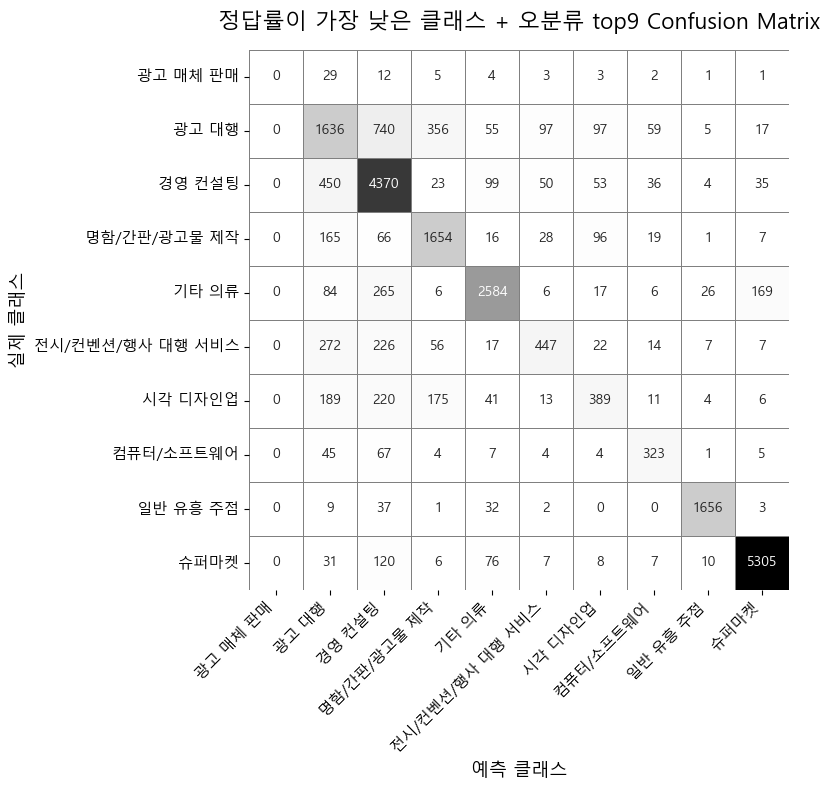

In [61]:
total_counts = cm.sum(axis=1)
correct_counts = np.diag(cm)
correct_ratio = correct_counts / (total_counts + 1e-8)

low_idx = np.argmin(correct_ratio)
low_class = unique_classes[low_idx]

row = cm[low_idx].copy()
row[low_idx] = 0
top9_wrong_idx = np.argsort(row)[-9:][::-1]

selected_idx = [low_idx] + list(top9_wrong_idx)
cm_sub = cm[np.ix_(selected_idx, selected_idx)]
class_labels = [unique_classes[i] for i in selected_idx]

plt.figure(figsize=(10, 8))
sns.heatmap(cm_sub,
            annot=True,
            fmt='d',
            cmap='Greys',
            xticklabels=class_labels,
            yticklabels=class_labels,
            linewidths=0.5,
            linecolor='gray',
            cbar=False,
            square=True
            )
plt.title('정답률이 가장 낮은 클래스 + 오분류 top9 Confusion Matrix', fontsize=16, pad=15)
plt.xlabel('예측 클래스', fontsize=13)
plt.ylabel('실제 클래스', fontsize=13)
plt.xticks(fontsize=11, rotation=45, ha='right')
plt.yticks(fontsize=11, rotation=0)
plt.tight_layout()
plt.show()

In [36]:
error_case_ads_df = test_query_df[
    (test_query_df['label'] == '광고 매체 판매') &
    ((test_query_df['pred'] == '광고 대행') |
     (test_query_df['pred'] == '경영 컨설팅'))
    ]
error_case_ads_df

,query,pred,label,prob
20892,미디어JR,광고 대행,광고 매체 판매,19.18%
45609,유업,경영 컨설팅,광고 매체 판매,6.52%
48307,쏘커뮤니케이션,광고 대행,광고 매체 판매,29.08%
52747,케이디엠코,경영 컨설팅,광고 매체 판매,11.73%
56436,니드랩,광고 대행,광고 매체 판매,6.70%
68668,한국방송광고진흥공사대전지사,광고 대행,광고 매체 판매,35.04%
73127,글로벌더원방송,광고 대행,광고 매체 판매,18.23%
79666,이지온커뮤니케이션,광고 대행,광고 매체 판매,24.44%
92533,브이엑트,광고 대행,광고 매체 판매,5.21%
117041,영등포제이제이컨설팅,경영 컨설팅,광고 매체 판매,40.72%


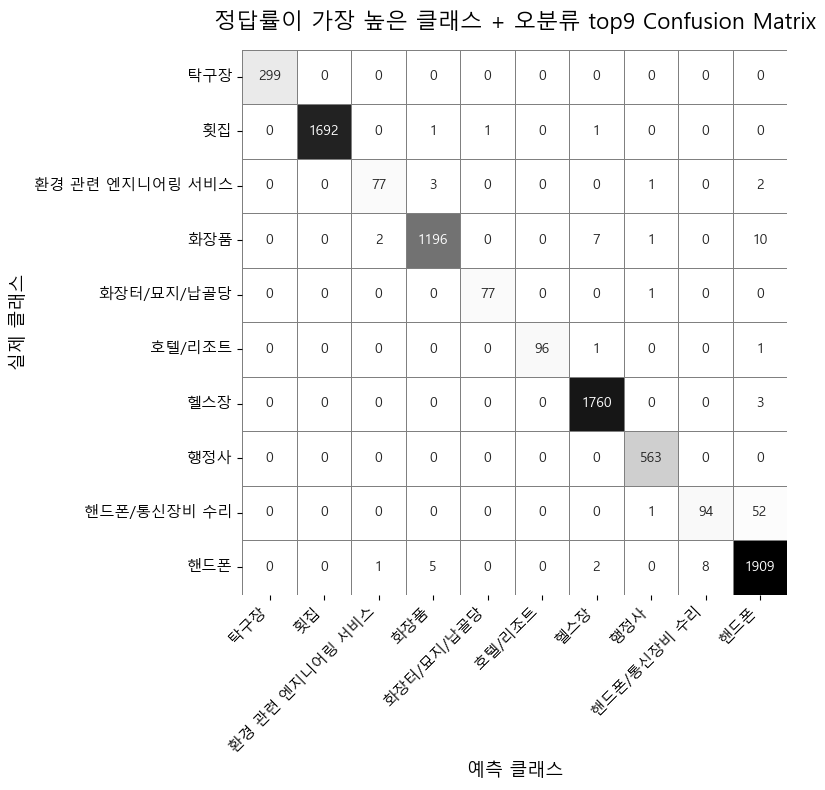

In [37]:
total_counts = cm.sum(axis=1)
correct_counts = np.diag(cm)
correct_ratio = correct_counts / (total_counts + 1e-8)

top_idx = np.argmax(correct_ratio)
top_class = unique_classes[top_idx]

row = cm[top_idx].copy()
row[top_idx] = 0  # 자기 자신 제외
top9_correct_idx = np.argsort(row)[-9:][::-1]

selected_idx = [top_idx] + list(top9_correct_idx)
cm_sub = cm[np.ix_(selected_idx, selected_idx)]
class_labels = [unique_classes[i] for i in selected_idx]

plt.figure(figsize=(10, 8))
sns.heatmap(cm_sub,
            annot=True,
            fmt='d',
            cmap='Greys',
            xticklabels=class_labels,
            yticklabels=class_labels,
            linewidths=0.5,
            linecolor='gray',
            cbar=False,
            square=True
            )
plt.title('정답률이 가장 높은 클래스 + 오분류 top9 Confusion Matrix', fontsize=16, pad=15)
plt.xlabel('예측 클래스', fontsize=13)
plt.ylabel('실제 클래스', fontsize=13)
plt.xticks(fontsize=11, rotation=45, ha='right')
plt.yticks(fontsize=11, rotation=0)
plt.tight_layout()
plt.show()

In [38]:
error_case_pinpong_df = test_query_df[test_query_df['label'] == '탁구장']
error_case_pinpong_df

,query,pred,label,prob
595,무인탁구장탁구핑24,탁구장,탁구장,97.18%
1769,금천킹탁구클럽,탁구장,탁구장,99.21%
2005,평화어울림탁구클럽,탁구장,탁구장,99.07%
2470,생활체육탁구장,탁구장,탁구장,99.47%
2931,와우탁구장,탁구장,탁구장,99.70%
...,...,...,...,...
358322,허브탁구장,탁구장,탁구장,99.65%
359413,강경주탁구클럽,탁구장,탁구장,99.06%
360957,은평탁구체육관,탁구장,탁구장,98.69%
361111,봉하탁구교실,탁구장,탁구장,98.77%


In [106]:
def plot_nth_lowest_accuracy_confusion(cm, unique_classes, n=1, topk=9):
    """
    cm: confusion_matrix (numpy array)
    unique_classes: 클래스 이름 리스트 (confusion_matrix의 labels 순서와 동일)
    n: 정답률이 낮은 순서에서 n번째 (1부터 시작)
    topk: 오분류 top k개
    """
    total_counts = cm.sum(axis=1)
    correct_counts = np.diag(cm)
    correct_ratio = correct_counts / (total_counts + 1e-8)
    
    # 정답률 낮은 순서대로 인덱스 정렬
    sorted_idx = np.argsort(correct_ratio)
    nth_idx = sorted_idx[n-1]  # n=1이면 가장 낮은 클래스
    
    row = cm[nth_idx].copy()
    row[nth_idx] = 0  # 자기 자신 제외
    topk_wrong_idx = np.argsort(row)[-topk:][::-1]
    
    selected_idx = [nth_idx] + list(topk_wrong_idx)
    cm_sub = cm[np.ix_(selected_idx, selected_idx)]
    class_labels = [unique_classes[i] for i in selected_idx]
    
    if n <= 0:
        title = f'{abs(n)+1}번째로 정답률이 높은 클래스 + 오분류 top{topk} Confusion Matrix'
    else:
        title = f'{n}번째로 정답률이 낮은 클래스 + 오분류 top{topk} Confusion Matrix'
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm_sub,
                annot=True,
                fmt='d',
                cmap='Greys',
                xticklabels=class_labels,
                yticklabels=class_labels,
                linewidths=0.5,
                linecolor='gray',
                cbar=False,
                square=True
                )
    ax = plt.gca()
    for spine in ['right', 'bottom']:
        ax.spines[spine].set_visible(True)
        ax.spines[spine].set_linewidth(1)
        ax.spines[spine].set_color('gray')
    plt.title(title, fontsize=16, pad=15, x=0.27)
    plt.xlabel('예측 클래스', fontsize=13)
    plt.ylabel('실제 클래스', fontsize=13)
    plt.xticks(fontsize=11, rotation=45, ha='right')
    plt.yticks(fontsize=11, rotation=0)
    plt.tight_layout()
    plt.show()

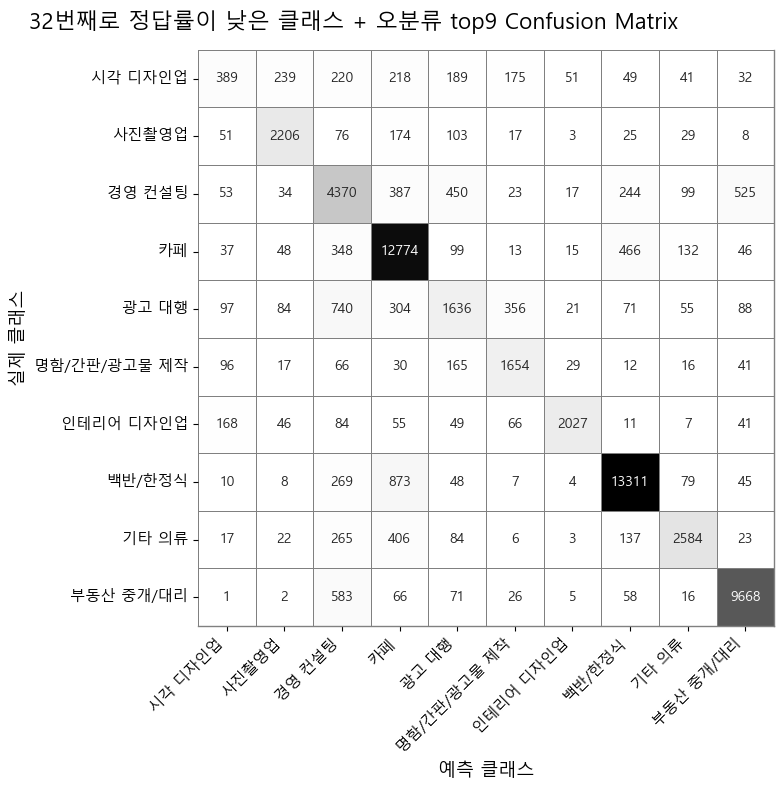

In [111]:
plot_nth_lowest_accuracy_confusion(cm, unique_classes, n=32, topk=9)

In [108]:
test_query_간이음식점_df = test_query_df[
    (test_query_df['label'] == '간이 음식점(기타)') | (test_query_df['pred'] == '간이 음식점(기타)')
    ]
test_query_간이음식점_df

,query,pred,label,prob
10,달콤왕가탕후루화도점,간이 음식점(기타),간이 음식점(기타),93.02%
81,냥냥탕후루,간이 음식점(기타),간이 음식점(기타),65.16%
186,횡성메밀,국수/칼국수,간이 음식점(기타),67.73%
477,뜰안분식,김밥/만두/분식,간이 음식점(기타),95.36%
588,팡송,빵/도넛,간이 음식점(기타),28.48%
...,...,...,...,...
362530,노란병아리,카페,간이 음식점(기타),9.09%
362846,고구마빵굽는이순신,빵/도넛,간이 음식점(기타),85.23%
363494,복가네명품만두찐빵,김밥/만두/분식,간이 음식점(기타),45.47%
363622,오두막호떡,간이 음식점(기타),간이 음식점(기타),46.48%


In [45]:
test_query_burger_df = test_query_df[(test_query_df['label'] == '버거')]
error_case_burger_df = test_query_df[(test_query_df['label'] == '버거') & (test_query_df['pred'] != '버거')]
test_query_burger_df

,query,pred,label,prob
470,롯데리아청주,버거,버거,98.34%
542,롯데리아용인둔전점,버거,버거,98.75%
1783,롯데리아부산학장점,버거,버거,98.05%
2038,프랭크버거삼척,버거,버거,99.63%
2192,버거팩토리,버거,버거,97.13%
...,...,...,...,...
360383,버거또,버거,버거,97.04%
361901,스테이플버거,버거,버거,94.83%
362390,프랭크버거장승배기역점,버거,버거,99.73%
362614,맘스터치수지,버거,버거,99.53%


In [46]:
error_case_burger_df

,query,pred,label,prob
36790,승한유에프오버거안산,패밀리레스토랑,버거,24.43%
49279,맥도날드대,피자,버거,45.66%
62176,칙바이칙,치킨,버거,11.99%
84125,밀크밥버거카톨릭관,김밥/만두/분식,버거,88.93%
115244,노브랜드버거 수유리우동서경대점,김밥/만두/분식,버거,75.54%
115517,오버거,카페,버거,5.27%
177453,맥도날드고양원당DT점,피자,버거,51.47%
211452,데카에셋롯데리아안양관,피자,버거,45.38%
215541,버거앤취킨,치킨,버거,62.47%
285411,브로스키친,경양식,버거,25.27%


---
### 모델 간 비교

In [47]:
history_bert_all = pickle.load(open('saved_model/bert-kor_all_2505100105/bert-kor_all_2505100105_history.pkl', 'rb'))
history_bert_MeCab = pickle.load(open('saved_model/bert-kor-mecab_all_2505071730/bert-kor-mecab_all2505071730_history.pkl', 'rb'))
history_bert_CNN = pickle.load(open('saved_model/bert-kor-cnn2_all_2505091730/bert-kor-cnn2_all_2505091730_history.pkl', 'rb'))
history_bert_CNN_W = pickle.load(open('saved_model/bert-kor-cnn_all_2505081630/bert-kor-cnn_all_2505081630_history.pkl', 'rb'))

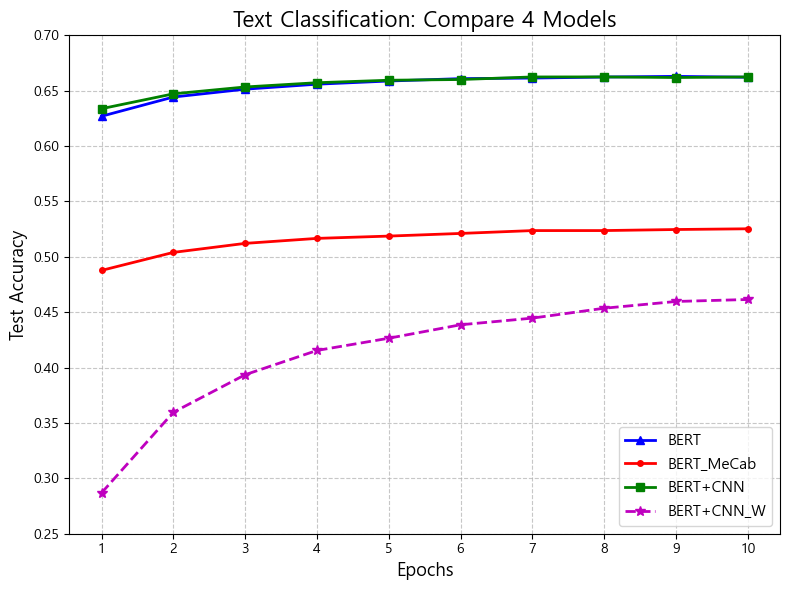

In [60]:
plt.figure(figsize=(8, 6))
plt.plot(history_bert_all["val_acc"], 'b^-', label='BERT', linewidth=2, markersize=6)
plt.plot(history_bert_MeCab["val_acc"], 'r.-', label='BERT_MeCab', linewidth=2, markersize=8)
plt.plot(history_bert_CNN["val_acc"], 'gs-', label='BERT+CNN', linewidth=2, markersize=6)
plt.plot(history_bert_CNN_W["val_acc"], 'm*--', label='BERT+CNN_W', linewidth=2, markersize=7)

plt.title('Text Classification: Compare 4 Models', fontsize=16)
plt.xlabel('Epochs', fontsize=13)
plt.ylabel('Test Accuracy', fontsize=13)

plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(range(10),range(1,11))
plt.ylim(0.25, 0.7)
plt.legend(loc='lower right', fontsize=11, frameon=True)
plt.tight_layout()
plt.show()

In [3]:
import pickle
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'Malgun Gothic'

history_bert_CNN = pickle.load(open('saved_model/bert-kor-cnn2_all_2505091730/bert-kor-cnn2_all_2505091730_history.pkl', 'rb'))
history_bert_BN = pickle.load(open('saved_model/bert-kor-cnn4_all_250622_0140/bert-kor-cnn4_all_250622_0140_history.pkl', 'rb'))
history_bert_BO = pickle.load(open('saved_model/bert-kor-cnn5_all_250623_0140/bert-kor-cnn5_all_250623_0140_history.pkl', 'rb'))
history_koelectra = pickle.load(open('saved_model/koelectra-cls_all_250623_0200/koelectra-cls_all_250623_0200_history.pkl', 'rb'))

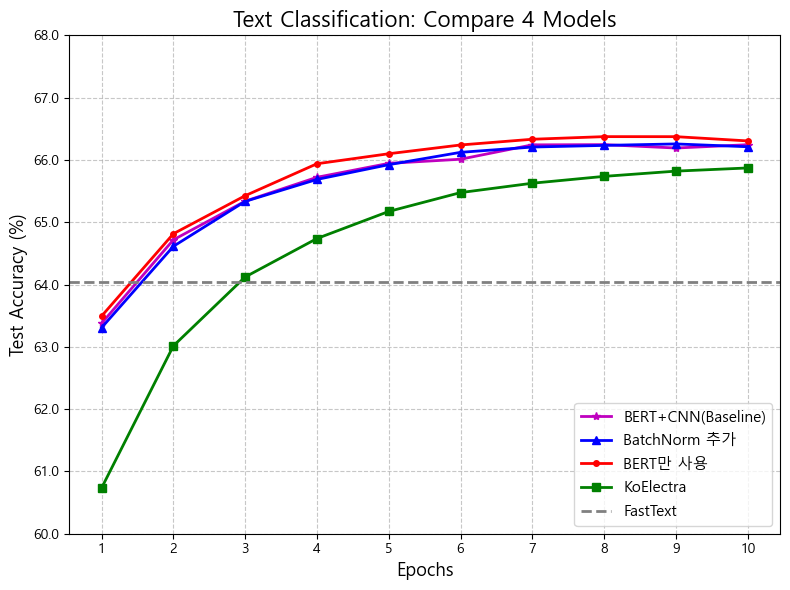

In [12]:
plt.figure(figsize=(8, 6))
plt.plot(history_bert_CNN["val_acc"], 'm*-', label='BERT+CNN(Baseline)', linewidth=2, markersize=6)
plt.plot(history_bert_BN["val_acc"], 'b^-', label='BatchNorm 추가', linewidth=2, markersize=6)
plt.plot(history_bert_BO["val_acc"], 'r.-', label='BERT만 사용', linewidth=2, markersize=8)
plt.plot(history_koelectra["val_acc"], 'gs-', label='KoElectra', linewidth=2, markersize=6)

fasttext_acc = 0.6404
plt.axhline(y=fasttext_acc, color='gray', linestyle='--', linewidth=2, label='FastText')

plt.title('Text Classification: Compare 4 Models', fontsize=16)
plt.xlabel('Epochs', fontsize=13)
plt.ylabel('Test Accuracy (%)', fontsize=13)

plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(range(10),range(1,11))
plt.ylim(0.6, 0.68)
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: '{:.1f}'.format(y*100)))
plt.legend(loc='lower right', fontsize=11, frameon=True)
plt.tight_layout()
plt.show()